In [1]:
import psycopg2
from sqlalchemy import create_engine, Column, Integer, String, Float, ForeignKey
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship, sessionmaker
import re
from __future__ import print_function

In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import pandas as pd
from nltk.stem.snowball import SnowballStemmer
import tensorflow as tf

In [3]:
dbname = 'restaurants'
username = 'andylane'
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)
con = None
con = psycopg2.connect(database = "restaurants", user = "andylane")
Session = sessionmaker(bind=engine)
session = Session()

postgres://andylane@localhost/restaurants


/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/sqlalchemy/dialects/__init__.py:34: SADeprecationWarning: The SQLAlchemy PostgreSQL dialect has been renamed from 'postgres' to 'postgresql'. The new URL format is postgresql[+driver]://<user>:<pass>@<host>/<dbname>
  module = __import__('sqlalchemy.dialects.%s' % (dialect, )).dialects


In [4]:
from menusights_aux import *

In [5]:
recipes = pd.read_sql("recipes", engine)

## Get recipe names into a vector

In [6]:
stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer("english")

## Match menu items to a cluster

In [7]:
recipes.head()

/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/IPython/core/formatters.py:98: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/IPython/core/formatters.py:677: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self)

,id,name,url,calories,fat,carbs,protein,cholesterol,sodium,servings
0,1,Fluffy Pancakes,http://allrecipes.com/recipe/162760/fluffy-pan...,230,8.2,32.7,6.4,65.0,650.0,4
1,2,Joan's Quick Chili,http://allrecipes.com/recipe/240622/joans-quic...,397,21.5,25.2,26.7,71.0,1438.0,4
2,3,Ultimate Double Chocolate Cookies,http://allrecipes.com/recipe/15097/ultimate-do...,148,6.8,21.4,2.2,25.0,88.0,42
3,4,Campfire Banana Splits,http://allrecipes.com/recipe/20038/campfire-ba...,545,17.3,106.2,4.7,0.0,47.0,6
4,5,Pumpkin Chocolate Chip Cookies II,http://allrecipes.com/recipe/10117/pumpkin-cho...,224,11.5,29.5,2.8,10.0,127.0,18


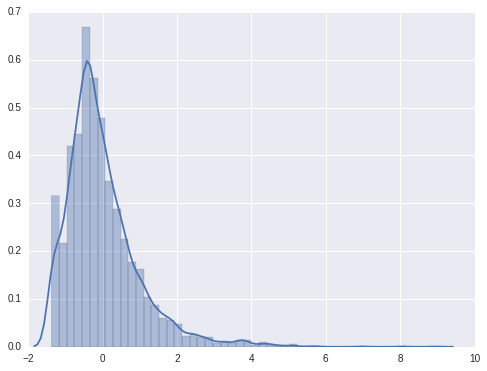

In [10]:
# Plot distribution of cholesterol etc; looks like it's normalish
from sklearn.preprocessing import scale
def normalize(item):
    a = scale(recipes[item], axis=0, with_mean=True, with_std=True, copy=True )
    return a

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
ax = sns.distplot(normalize("cholesterol"), label="chol")
#ax = sns.distplot(normalize("calories"))
#ax = sns.distplot(normalize("protein"))

In [9]:
def tokenize_and_stem(title):
    stemmer = SnowballStemmer("english")
    stemmed_titles = []
    new_title=[]
    for word in nltk.word_tokenize(title):
        new_title.append(stemmer.stem(word))
    stemmed_titles.extend(new_title)
    return " ".join([i for i in stemmed_titles])

In [11]:
tokenized_names = [tokenize_and_stem(i) for i in (recipes["name"])]

In [ ]:
tokenized_names[99]

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
vectorizer = CountVectorizer(ngram_range=(1,3), min_df=0.0003)

In [14]:
a = vectorizer.fit_transform(tokenized_names)

In [15]:
len(vectorizer.get_feature_names())

3453

In [16]:
a

<3941x3453 sparse matrix of type '<type 'numpy.int64'>'
	with 28567 stored elements in Compressed Sparse Row format>

In [17]:
vectorizer.vocabulary_.get('minc')

1969

In [18]:
vectorizer.get_feature_names()[2256]

u'pie'

In [19]:
sum(a.toarray()[:,2701])

208

In [20]:
from sklearn.feature_selection import f_regression, mutual_info_regression

In [21]:
# produces an array with mutual information (weights?) between individual words/n-grams in recipe names and cholesterol information
mi = mutual_info_regression(a, recipes["cholesterol"])
mi /= np.max(mi)

In [22]:
#[(index, i, vectorizer.get_feature_names()[index]) for index, i in enumerate(mi) if i>0.01]

[(0, 0.019422527770953772, u'acorn'),
 (1, 0.019422527770953772, u'acorn squash'),
 (7, 0.014865655586902169, u'aioli'),
 (9, 0.063034048743356955, u'al tonno'),
 (13, 0.031591162213226893, u'alfredo'),
 (14, 0.021684946062962202, u'alfredo pasta'),
 (20, 0.013627996718424792, u'almond'),
 (22, 0.021555947352981324, u'almond chicken'),
 (27, 0.024726302234324621, u'amaz pork tenderloin'),
 (29, 0.010263549431077651, u'amish'),
 (31, 0.011775715953625719, u'and almond'),
 (47, 0.014508829315116201, u'and blue'),
 (52, 0.048755366732576119, u'and broccoli'),
 (53, 0.010592645885868316, u'and broccoli pasta'),
 (60, 0.01019832932473704, u'and cauliflow'),
 (66, 0.027352795760279536, u'and chicken'),
 (71, 0.016403846667356618, u'and coconut'),
 (82, 0.046196069171825553, u'and dumpl'),
 (84, 0.014690149176446758, u'and easi chicken'),
 (86, 0.043798907735924424, u'and egg'),
 (87, 0.050664443878828014, u'and egg salad'),
 (88, 0.014087938507014583, u'and fast'),
 (93, 0.035936163465733528

In [23]:
# Returns indices of columns with MI value greater than e.g. 0.01. Can be used for re
informative_words = np.array([(index) for index, i in enumerate(mi) if i>0.01])
# return word vector array with uninformative words removeds
culled_array = a.toarray()[:,informative_words]

In [44]:
culled_array.shape

(3941, 3453)

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from sklearn import datasets, linear_model


X_train = culled_array
y_train = recipes["cholesterol"]

X_test = a[:200]
y_test = recipes["cholesterol"][:200]

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [ ]:
# Try fitting an elasticnet model!
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
enet = ElasticNet()
enetmodel=enet.fit(culled_array[200:], y_train[200:])
y_predicted = enetmodel.predict(culled_array[:200])
# Evaluate by comparing predicted cholesterol to actual cholesterol
r2_score_enet = r2_score(y_test, y_predicted)
r2_score_enet #oh no it's -0.29...

In [26]:
import cPickle as pkl

In [27]:
ground_truth_x =[]
ground_truth_y =[]
for item in pkl.load(open("groundtruth.pkl", "rb")):
    ground_truth_x.append(item["item_name"])
    ground_truth_y.append(item["nf_cholesterol"])

In [28]:
tokenized_names_ground_truth = [tokenize_and_stem(i) for i in (ground_truth_x)]

In [29]:
# Puts words from new ground truth set into matrix from training set
ground_truth_vectorized = vectorizer.transform(tokenized_names_ground_truth)

In [30]:
ground_truth_vectorized_culled_array = ground_truth_vectorized.toarray()[:,informative_words]
y_predicted = enetmodel.predict(ground_truth_vectorized_culled_array)
r2_score_enet = r2_score(ground_truth_y, y_predicted)
r2_score_enet #oh no it's still bad...

NameError: name 'enetmodel' is not defined

In [ ]:
x,y = pd.Series(ground_truth_y, name="x_var"), pd.Series(y_predicted, name="y_var")
ax = sns.regplot(x=x, y=y)

## So, the elasticnet model (a linear regression) has poor predictive power at default parameters. Can we optimize the parameters?

In [42]:
%matplotlib inline
# Compute paths
from sklearn.linear_model import ElasticNetCV
import time, copy
from sklearn.metrics import r2_score

def enetcv(culled_array, y_train, ground_truth_vectorized_culled_array, ground_truth_y):
    #culledarrayecv = np.sqrt(np.sum(culledarrayecv ** 2, axis=0)) / culledarrayecv
    model = ElasticNetCV(cv=100).fit(culled_array, y_train)
    m_log_alphas = -np.log10(model.alphas_)
    y_predicted_cv = model.predict(ground_truth_vectorized_culled_array)
    x,y = pd.Series(ground_truth_y, name="actual cholesterol"), pd.Series(y_predicted_cv, name="predicted cholesterol")
    ax = sns.regplot(x=x, y=y)
    return r2_score(ground_truth_y, y_predicted_cv) 

0.13064617575639881

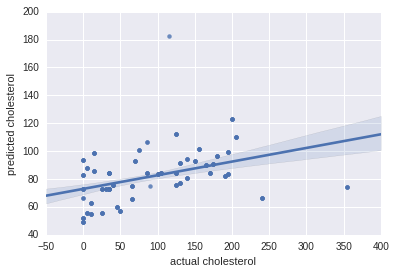

In [45]:
enetcv(a, y_train, ground_truth_vectorized, ground_truth_y)

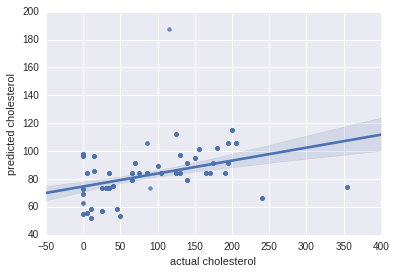

In [46]:
ax = sns.regplot(x=x, y=y)


## woohoo with an optimized elasticnet model, there's a 0.13705 Rsq

In [ ]:
plt.figure()
ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

### How about if I try to add position-weights to words?

In [ ]:
def tokenize_and_stem_with_position_weights(title):
    stemmer = SnowballStemmer("english")
    stemmed_titles = []
    new_title=[]
    for index, word in enumerate(nltk.word_tokenize(title)):
        rindex = abs(index - len(nltk.word_tokenize(title)))
        new_title.append(str(stemmer.stem(word).encode("utf-8") + str(rindex)))
    stemmed_titles.extend(new_title)    
    return " ".join([i for i in stemmed_titles])

In [ ]:
tokenized_names_pos = [tokenize_and_stem_with_position_weights(i) for i in (recipes["name"])]

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1,3), min_df=0.0003)
a = vectorizer.fit_transform(tokenized_names_pos)
mi = mutual_info_regression(a, recipes["cholesterol"])
mi /= np.max(mi)

In [ ]:
# Returns indices of columns with MI value greater than e.g. 0.01. Can be used for re
informative_words = np.array([(index) for index, i in enumerate(mi) if i>0.01])
# return word vector array with uninformative words removeds
culled_array = a.toarray()[:,informative_words]

X_train = culled_array
y_train = recipes["cholesterol"]

X_test = culled_array[:200]
y_test = recipes["cholesterol"][:200]

# Try fitting an elasticnet model!
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
enet = ElasticNet()
enetmodel=enet.fit(culled_array, y_train)
y_predicted = enetmodel.predict(X_test)
# Evaluate by comparing predicted cholesterol to actual cholesterol
r2_score_enet = r2_score(y_test, y_predicted)
r2_score_enet #oh no it's -0.29...
print(r2_score_enet)

# Validate against ground_truth
tokenized_names_ground_truth = [tokenize_and_stem_with_position_weights(i) for i in (ground_truth_x)]
ground_truth_vectorized = vectorizer.transform(tokenized_names_ground_truth)
ground_truth_vectorized_culled_array = ground_truth_vectorized.toarray()[:,informative_words]
y_predicted = enetmodel.predict(ground_truth_vectorized_culled_array)
r2_score_enet = r2_score(ground_truth_y, y_predicted)
r2_score_enet #oh no it's still bad...
print(r2_score_enet)

#Try optimizing ENet (validated across ground truth)
model = ElasticNetCV(cv=20).fit(culled_array, y_train)
m_log_alphas = -np.log10(model.alphas_)
y_predicted_cv = model.predict(ground_truth_vectorized_culled_array)
r2_score_enet = r2_score(ground_truth_y, y_predicted_cv)
print(r2_score_enet) #0.056...

In [ ]:
### Hmm. The ElasticNet CV optimization still maxes out at 0.056

## Try Ridge Regression

In [ ]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha = .5)
rrfit = reg.fit(culled_array, recipes["cholesterol"]) 

In [ ]:
y_predicted = rrfit.predict(ground_truth_vectorized_culled_array)
# Evaluate by comparing predicted cholesterol to actual cholesterol
r2_score_rrfit = r2_score(ground_truth_y, y_predicted)
print(r2_score_rrfit) # -0.009 - not great still 

In [ ]:
ground_truth_y

In [ ]:
model = linear_model.RidgeCV(cv=100).fit(culled_array, recipes["cholesterol"])
m_log_alphas = -np.log10(model.alpha_)
y_predicted_cv = model.predict(ground_truth_vectorized_culled_array)
r2_score_rrfitcv = r2_score(ground_truth_y, y_predicted_cv)
print(r2_score_rrfitcv) #0.056... or 0.119 with 100cv